In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


Black-Scholes Model Functions

In [ ]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    return price

def implied_volatility(S, K, T, r, market_price, option_type='call'):
    def objective_function(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price

    low_vol = 1e-5
    high_vol = 1.0

    while objective_function(high_vol) * objective_function(low_vol) > 0:
        high_vol *= 2
        if high_vol > 10:
            raise ValueError("Market price is out of realistic range for implied volatility calculation.")

    implied_vol = brentq(objective_function, low_vol, high_vol)
    return implied_vol

def monte_carlo_simulation(S, K, T, r, sigma, simulations=10000, option_type='call'):
    np.random.seed(0)
    Z = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)
    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - ST, 0)
    call_price = np.exp(-r * T) * np.mean(payoff)
    return call_price


Binomial Tree for American call

In [ ]:
def binomial_tree_american_call(S, K, T, r, sigma, steps):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    prices = np.zeros(steps + 1)
    prices[0] = S * d**steps
    for i in range(1, steps + 1):
        prices[i] = prices[i - 1] * u / d

    # Initialize option values at maturity
    values = np.maximum(prices - K, 0)

    # Backward induction
    for step in range(steps - 1, -1, -1):
        for i in range(step + 1):
            values[i] = np.exp(-r * dt) * (p * values[i + 1] + (1 - p) * values[i])
            prices[i] = prices[i] / d
            values[i] = np.maximum(values[i], prices[i] - K)  # American option

    return values[0]


Fetching Market Data

In [ ]:
def fetch_market_data(ticker):
    stock = yf.Ticker(ticker)
    data = stock.history(period="1d")
    current_price = data['Close'].iloc[-1]
    return current_price


Sensitivity Analysis

In [ ]:
def sensitivity_analysis(S, K, T, r, sigma, ticker, option_type='european'):
    S_range = np.linspace(S * 0.8, S * 1.2, 100)
    if option_type == 'european':
        call_prices = [black_scholes(s, K, T, r, sigma, 'call') for s in S_range]
    elif option_type == 'american':
        call_prices = [binomial_tree_american_call(s, K, T, r, sigma, 100) for s in S_range]

    plt.figure(figsize=(10, 5))
    plt.plot(S_range, call_prices, label='Call Option Price')
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Price')
    plt.title(f'Option Prices vs Stock Price for {ticker}')
    plt.legend()
    plt.show()


Plot for Implied Volatility

In [ ]:
def plot_implied_volatility_surface(S, K_list, T_list, r, market_prices, ticker, option_type='european'):
    implied_vol_surface = np.zeros((len(K_list), len(T_list)))

    for i, K in enumerate(K_list):
        for j, T in enumerate(T_list):
            market_price = market_prices[i, j]
            try:
                implied_vol_surface[i, j] = implied_volatility(S, K, T, r, market_price, 'call')
            except ValueError:
                implied_vol_surface[i, j] = np.nan

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    K_mesh, T_mesh = np.meshgrid(K_list, T_list)
    ax.plot_surface(K_mesh, T_mesh, implied_vol_surface.T)
    ax.set_xlabel('Strike Price (K)')
    ax.set_ylabel('Time to Maturity (T)')
    ax.set_zlabel('Implied Volatility')
    plt.title(f'Implied Volatility Surface for {ticker}')
    plt.show()



Generate Market Prices

In [ ]:
def generate_market_prices(S, K_list, T_list, r, option_type='european'):
    market_prices = np.zeros((len(K_list), len(T_list)))
    sigma = 0.2

    for i, K in enumerate(K_list):
        for j, T in enumerate(T_list):
            if option_type == 'european':
                market_price = black_scholes(S, K, T, r, sigma, 'call')
            elif option_type == 'american':
                market_price = binomial_tree_american_call(S, K, T, r, sigma, 100)
            noise = market_price * 0.01 * np.random.randn()
            market_prices[i, j] = max(market_price + noise, 0)

    return market_prices



Main Function

Call Price: 51.375839614865896, Put Price: 0.9402581727854997
Implied Volatility: 0.2000000000000009
Monte Carlo Call Price: 50.53944955786562


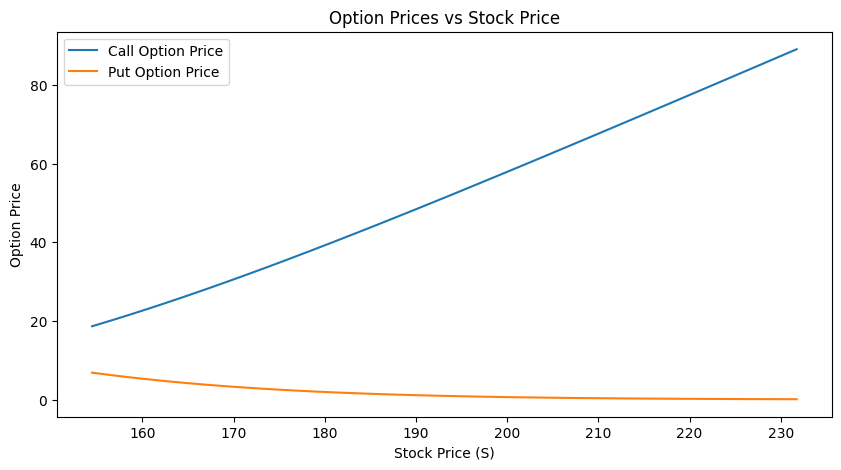

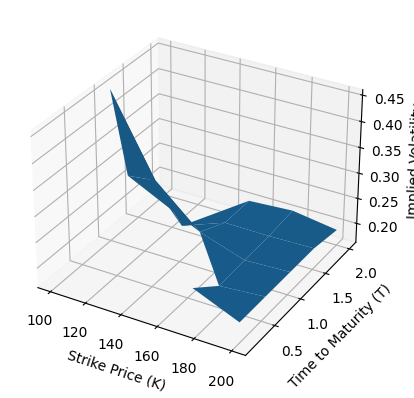

In [ ]:
def main():
    ticker = "AAPL"
    S = fetch_market_data(ticker)
    K = 150
    T = 1
    r = 0.05
    sigma = 0.2

    call_price = black_scholes(S, K, T, r, sigma, 'call')
    put_price = black_scholes(S, K, T, r, sigma, 'put')
    print(f"Call Price: {call_price}, Put Price: {put_price}")

    market_price = call_price
    try:
        implied_vol = implied_volatility(S, K, T, r, market_price, 'call')
        print(f"Implied Volatility: {implied_vol}")
    except ValueError as e:
        print(f"Error calculating implied volatility: {e}")

    mc_call_price = monte_carlo_simulation(S, K, T, r, sigma, 10000, 'call')
    print(f"Monte Carlo Call Price: {mc_call_price}")

    sensitivity_analysis(S, K, T, r, sigma)

    K_list = np.linspace(100, 200, 5)
    T_list = np.linspace(0.1, 2, 5)
    market_prices = generate_market_prices(S, K_list, T_list, r)
    plot_implied_volatility_surface(S, K_list, T_list, r, market_prices)

if __name__ == "__main__":
    main()


Enter tickers separated by commas: GOOGL, AAPL
Enter option type (european/american): american
GOOGL - Call Price: 34.84505934424025


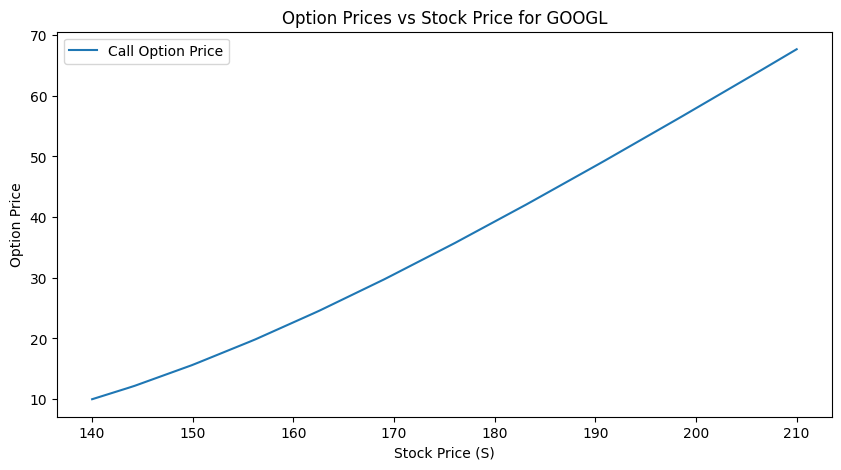

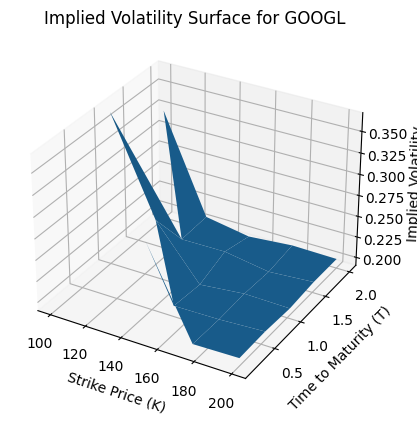

AAPL - Call Price: 51.378781008821285


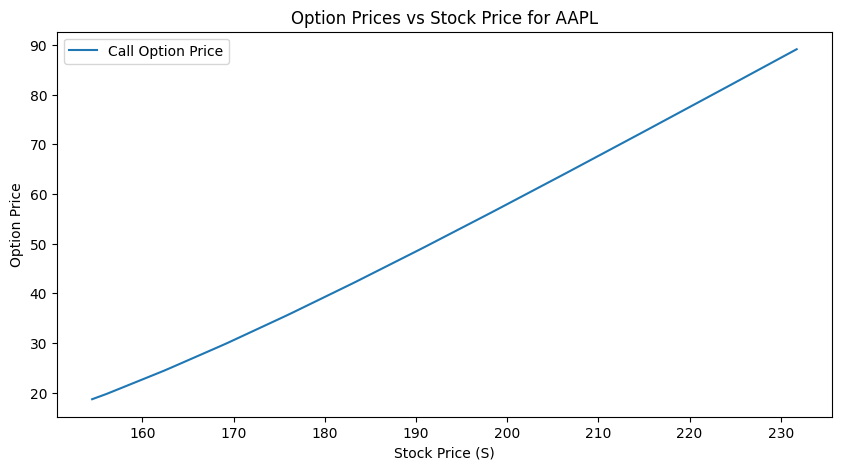

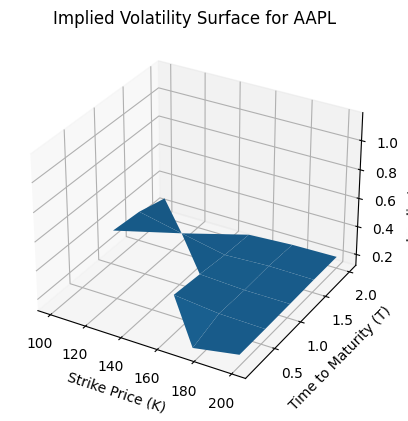

In [ ]:
def main():
    tickers_input = input("Enter tickers separated by commas: ")
    tickers = [ticker.strip() for ticker in tickers_input.split(',')]
    option_type_input = input("Enter option type (european/american): ").lower()
    option_type = 'european' if option_type_input == 'european' else 'american'

    K = 150
    T = 1
    r = 0.05
    sigma = 0.2

    for ticker in tickers:
        try:
            S = fetch_market_data(ticker)
            if option_type == 'european':
                call_price = black_scholes(S, K, T, r, sigma, 'call')
            elif option_type == 'american':
                call_price = binomial_tree_american_call(S, K, T, r, sigma, 100)
            print(f"{ticker} - Call Price: {call_price}")

            sensitivity_analysis(S, K, T, r, sigma, ticker, option_type)

            K_list = np.linspace(100, 200, 5)
            T_list = np.linspace(0.1, 2, 5)
            market_prices = generate_market_prices(S, K_list, T_list, r, option_type)
            plot_implied_volatility_surface(S, K_list, T_list, r, market_prices, ticker, option_type)

        except Exception as e:
            print(f"Error processing {ticker}: {e}")

if __name__ == "__main__":
    main()

